# Example End-to-End Simulation

This notebook provides a brief example of how one could run an end-to-end simulation using the tools available in `hera_sim`. For further details on how to simulate visibilities, please refer to the visibility simulator tutorial. For further details on applying systematics, please refer to the `Simulator` tutorial.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from astropy import units, constants

import hera_sim
from hera_sim import Simulator, DATA_PATH
from hera_sim.visibilities import MatVis, ModelData, VisibilitySimulation
import pyuvsim
import pyuvdata
import uvtools

import pyradiosky
import matvis
from astropy.coordinates import Latitude, Longitude

In [2]:
print(
    f"""
Using the following software versions:
    hera_sim  : {hera_sim.__version__}
    pyuvdata  : {pyuvdata.__version__}
    pyuvsim   : {pyuvsim.__version__}
    pyradiosky: {pyradiosky.__version__}
    matvis    : {matvis.__version__}
    """
)


Using the following software versions:
    hera_sim  : 4.2.3.dev63+g0e040d1.d20240822
    pyuvdata  : 3.0.0
    pyuvsim   : 1.3.2.dev12+g685ee72
    pyradiosky: 1.0.1
    matvis    : 1.2.1
    


## Simulating Visibilities

Visibilities can be simulated using any of the simulation packages that `hera_sim` has wrapped. Simulators that have been wrapped by `hera_sim` all have the ability to interpret `pyuvsim`-style configuration files and store the simulated data in `UVData` objects under the hood. The currently supported simulation packages include `pyuvsim`, `matvis` and `fftvis`. Each simulator has its own advantages and disadvantages&mdash;we encourage you to experiment with various simulators. If you would like to see another visibility simulator wrapped by `hera_sim`, then please file an issue making a feature request.

In [3]:
cfg_path = DATA_PATH / "tutorials_data/end_to_end"
obsparam_file = cfg_path / "obsparams.yaml"

This tutorial provides a minimal configuration file for reference. It contains a minimal set of information required to initialize the various objects needed for running a simulation. Each configuration file should specify enough information to fully specify the frequencies sampled, the times observed, the telescope parameters, and the sky model parameters. For a more complete description of what may go into a configuration file (and its linked files), please refer to the `pyuvsim` documentation.

In [4]:
# Take a quick look at what's in the configuration file.
with open(obsparam_file) as param_file:
    print(param_file.read())

# Specify the frequencies sampled.
freq:
    Nfreqs: 100
    start_freq: 140000000.0
    bandwidth: 20000000.0
# Specify the times observed.
time:
    Ntimes: 200
    start_time: 2458119.5
    integration_time: 10.7
# Specify where to find the telescope parameters.
telescope:
    array_layout: 'array_layout.csv'
    telescope_config_name: 'telescope.yaml'
# Define the source catalog.
sources:
    catalog: 'sample_catalog.txt'
    spectral_type: 'full'



In [5]:
# # Code for making the array_layout.csv file
# import csv
# fields = ["Name", "Number", "BeamID", "E", "N", "U"]
# antpos = hera_sim.antpos.hex_array(2, split_core=False, outriggers=0)
# ant_to_beam = np.zeros(len(antpos), dtype=int)
# rows = list(
#     [f"ANT{ant}", ant, ant_to_beam[ant], e, n, u]
#     for ant, (e, n, u) in antpos.items()
# )
#
# Write the array to a csv file.
# csv_path = cfg_path / "array_layout.csv"
# with open(csv_path, "w") as f:
#     writer = csv.writer(f, delimiter=' ')
#     writer.writerow(fields)
#     writer.writerow([])
#     writer.writerows(rows)

Here we create an instance of a `ModelData` object from the configuration file using the `from_config` class method. For reference, a `ModelData` object contains both the sky model (as a `pyradiosky.SkyModel` object), the visibility data/metadata (as a `pyuvdata.UVData` object), and the beam information (managed with a collection of `pyuvdata.UVBeam` objects).

In [6]:
data_model = ModelData.from_config(str(obsparam_file))

The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.


The visibility simulation is handled by the `VisibilitySimulation` class, which requires a `ModelData` object and a `VisibilitySimulator` object in order to be initialized. The `VisibilitySimulator` handles the actual process of simulating the visibilities, while the `ModelData` object contains all of the information necessary to run the simulation. Here, we use `vis_cpu` to perform the visibility simulation.

In [7]:
matvis_sim = VisibilitySimulation(data_model=data_model, simulator=MatVis())

In [8]:
%%time

# Actually simulate the visibilities.
matvis_sim.simulate();

CPU times: user 3.2 s, sys: 10 ms, total: 3.21 s
Wall time: 3.22 s


In [9]:
pos, ants = data_model.uvdata.get_ENU_antpos()
antpos = dict(zip(ants, pos))
ai, aj = antpair = (2, 4)
baseline = antpos[aj] - antpos[ai]
bl_len_ns = np.linalg.norm(baseline) / constants.c.to("m/ns").value

In [10]:
plot_kwargs = dict(
    antpairpol=(2, 4, "xx"),
    plot_limits={"fringe-rate": (8, -8), "delay": (-1200, 1200)},
    freq_taper="blackman-harris",
    time_taper="blackman-harris",
    dynamic_range={"delay": 5, "fringe-rate": 5},
    set_title=f"{antpair + ('xx',)}\n" + r"$|\vec{b}|$/c = " + f"{bl_len_ns:.2f} ns",
)

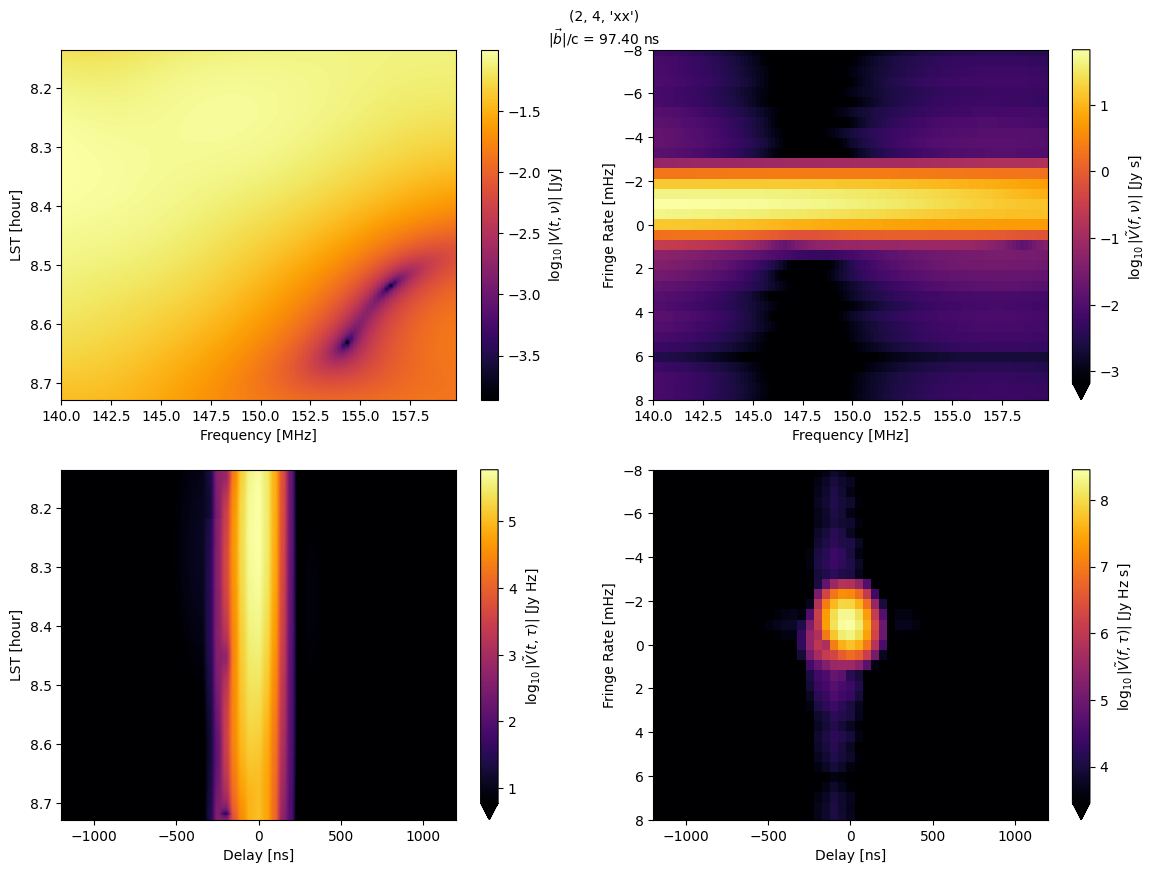

In [11]:
# Plot one visibility and its various transforms.
fig = uvtools.plot.fourier_transform_waterfalls(
    matvis_sim.data_model.uvdata, **plot_kwargs
)

**Figure 1 |** Visibility waterfall, and its various transforms, for an East-West oriented baseline.

## Applying Systematics

The `hera_sim.Simulator` class provides a simple interface for applying systematic effects to a provided set of data. Here, we use the simulated visibilities from the previous step to create a `Simulator` object and proceed to apply a few different sytematic effects to the simulated data.

In [12]:
sim = Simulator(data=matvis_sim.data_model.uvdata.copy())

The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.


In [13]:
# Just so we don't need to specify too many parameters
hera_sim.defaults.set("h1c")

In [14]:
systematics = {
    "gains": {"seed": "once"},  # Bandpass gains
    "reflections": {  # Cable reflections
        "amp": 1e-2,
        "dly": 250,
        "amp_jitter": 5e-2,
        "dly_jitter": 5,
        "seed": "once",
    },
    "cross_coupling_spectrum": {  # Cross-coupling
        "dly_range": (800, 1000),
        "amp_range": (-2, -4),
        "amp_jitter": 1e-2,
        "dly_jitter": 20,
        "seed": "once",
    },
}

We can apply all of the systematic effects parametrized above by using the `run_sim` method. This simulates and applies the effects in the provided dictionary in the same order as they appear in the dictionary. If you are worried about the ordering of the dictionary (which should not be a concern for Python 3.7 and later), then you should use an `OrderedDict`.

In [15]:
sim.run_sim(**systematics)

You are adding visibilities to a data array *after* multiplicative effects have been introduced.


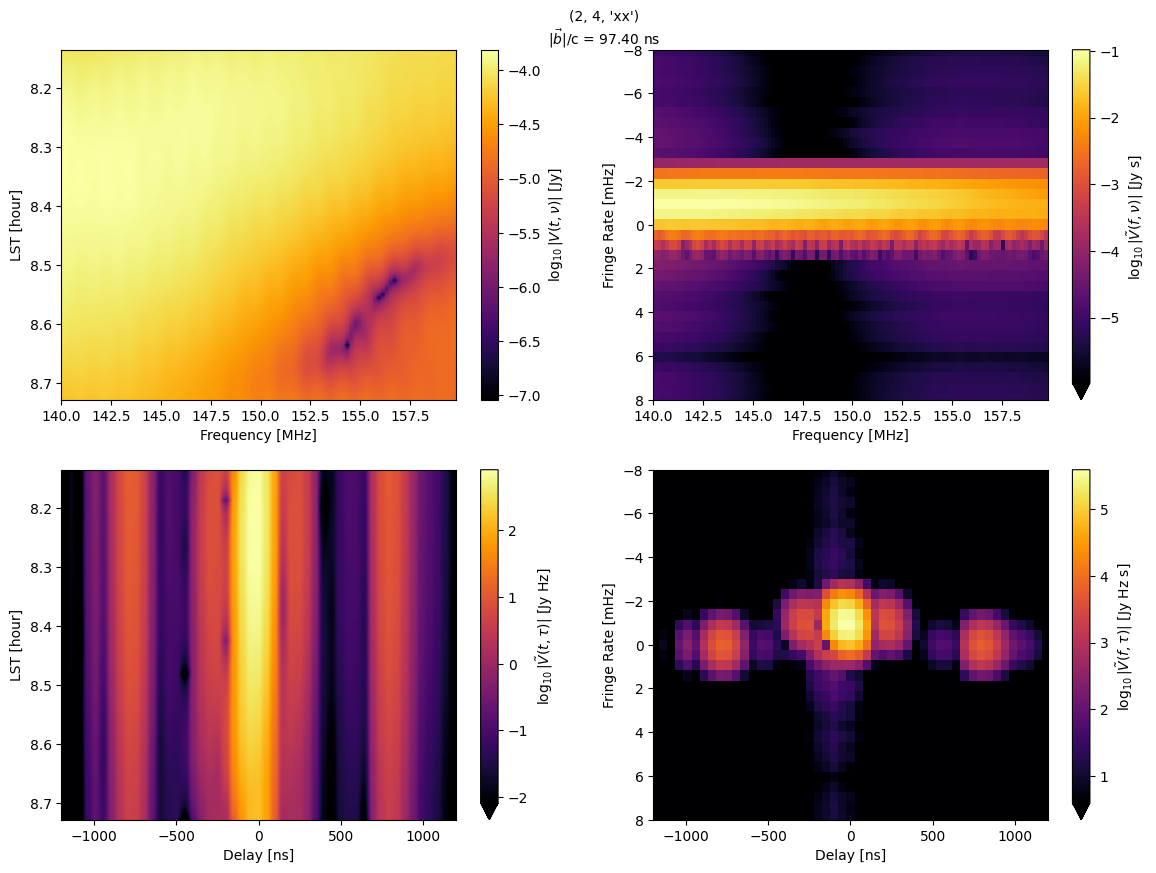

In [16]:
# Plot the data!
fig = uvtools.plot.fourier_transform_waterfalls(sim.data, **plot_kwargs)

**Figure 2 |** Simulated visibilities with systematic effects (bandpass gains, cable reflections, and cross-coupling) applied.